In [1]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation


Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 96%|███████████████████████████████████████▍ | 687M/714M [00:02<00:00, 317MB/s]
100%|█████████████████████████████████████████| 714M/714M [00:02<00:00, 282MB/s]


In [2]:
!pip install kaggle

In [ ]:
import zipfile

with zipfile.ZipFile('lgg-mri-segmentation.zip', 'r') as zip_ref:
    files_to_extract = [f for f in zip_ref.namelist() if f.startswith("kaggle_3m/")]
    
    zip_ref.extractall('/kaggle/working/lgg_mri_segmentation', members=files_to_extract)


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


In [ ]:

from PIL import Image


def check_tumor_in_mask(mask_path):
    try:
        img = Image.open(mask_path)
        img = np.array(img)

        if np.max(img) > 0:
            return 1 
        else:
            return 0 
    except Exception as e:
        print(f"Erreur de lecture du masque {mask_path}: {e}")
        return -1 

DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"

dirs = []
images = []
masks = []
diagnoses = []

for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask' in filename:  
           
            mask_path = os.path.join(dirname, filename)
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            
            images.append(filename.replace('_mask', '')) 
            diagnosis = check_tumor_in_mask(mask_path)
            diagnoses.append(diagnosis)

patient_mri_df = pd.DataFrame({'patient_id': dirs, 'images': images, 'masks': masks, 'diagnosis': diagnoses})

patient_mri_df.head()


,patient_id,images,masks,diagnosis
0,TCGA_DU_7309_19960831,TCGA_DU_7309_19960831_40.tif,TCGA_DU_7309_19960831_40_mask.tif,0
1,TCGA_DU_7309_19960831,TCGA_DU_7309_19960831_3.tif,TCGA_DU_7309_19960831_3_mask.tif,0
2,TCGA_DU_7309_19960831,TCGA_DU_7309_19960831_7.tif,TCGA_DU_7309_19960831_7_mask.tif,0
3,TCGA_DU_7309_19960831,TCGA_DU_7309_19960831_34.tif,TCGA_DU_7309_19960831_34_mask.tif,0
4,TCGA_DU_7309_19960831,TCGA_DU_7309_19960831_15.tif,TCGA_DU_7309_19960831_15_mask.tif,0


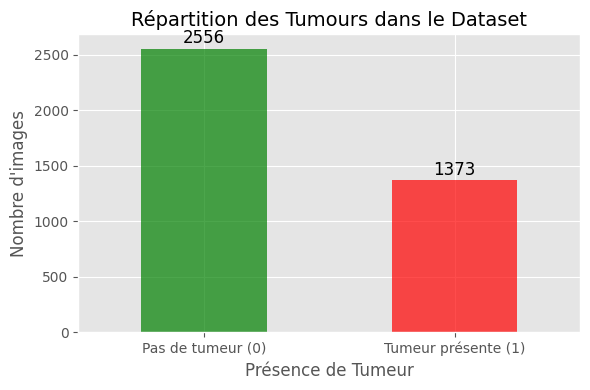

In [6]:
import matplotlib.pyplot as plt
diagnosis_counts = patient_mri_df['diagnosis'].value_counts()

plt.figure(figsize=(6, 4))
diagnosis_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title('Répartition des Tumours dans le Dataset', fontsize=14)
plt.xlabel('Présence de Tumeur', fontsize=12)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Pas de tumeur (0)', 'Tumeur présente (1)'], rotation=0)
for i, count in enumerate(diagnosis_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()


In [7]:
pip install imageio


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


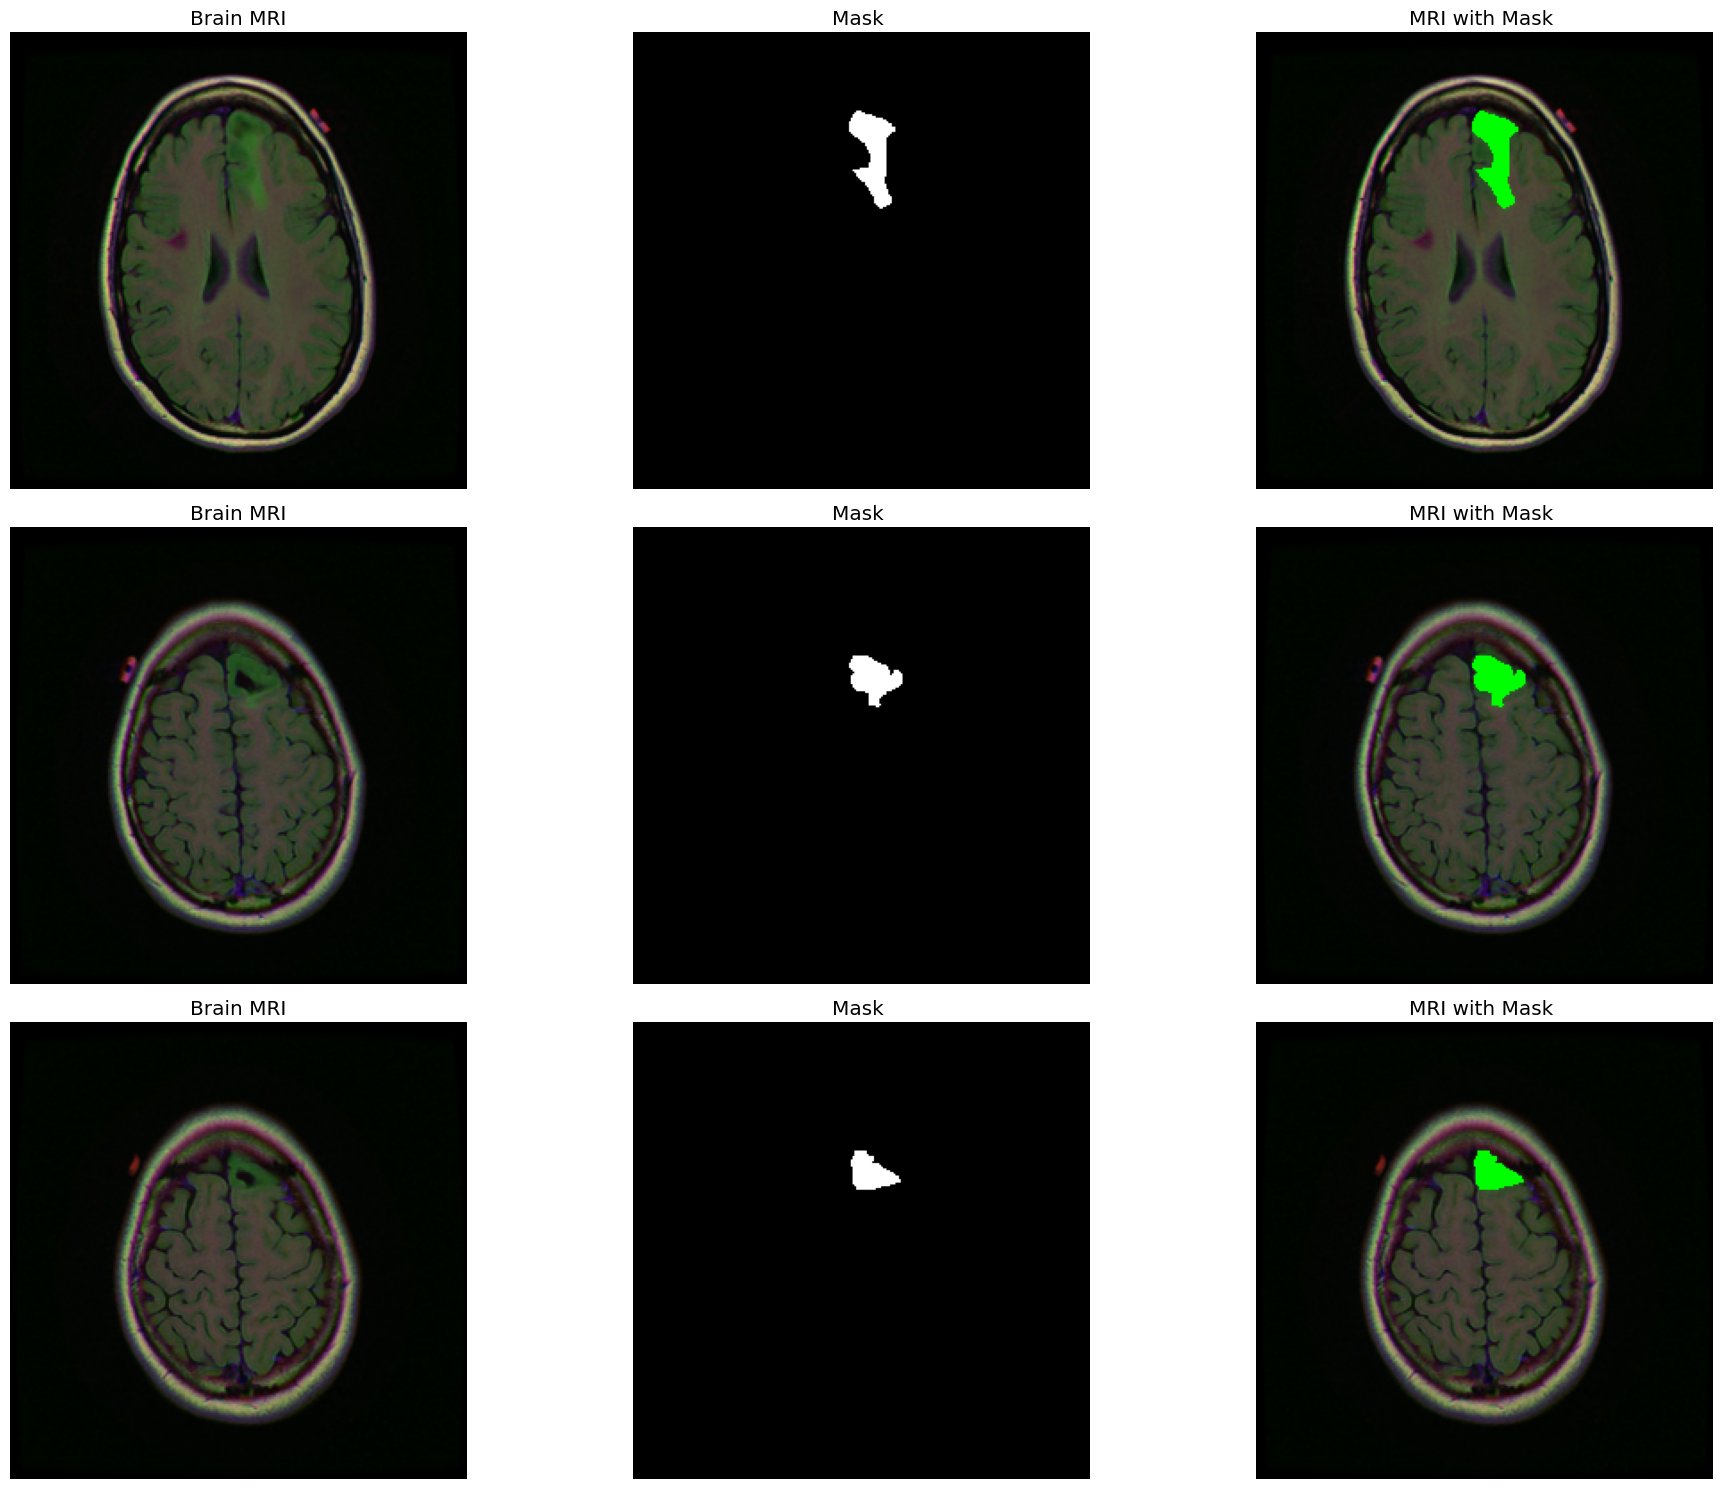

In [ ]:
import os
from skimage.io import imread
import matplotlib.pyplot as plt

count = 0
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()

for i, row in patient_mri_df.iterrows():
    if row['diagnosis'] == 1:
        img_path = os.path.join(DataPath, row['patient_id'], row['images'])
        mask_path = os.path.join(DataPath, row['patient_id'], row['masks'])

        img = imread(img_path)  
        mask = imread(mask_path)  

        axs[count].imshow(img)
        axs[count].set_title("Brain MRI")
        axs[count].axis('off')

        axs[count + 1].imshow(mask, cmap='gray')
        axs[count + 1].set_title(f"Mask ")
        axs[count + 1].axis('off')

        img_with_mask = img.copy()
        img_with_mask[mask == 255] = (0, 255, 0)
        axs[count + 2].imshow(img_with_mask)
        axs[count + 2].set_title(f"MRI with Mask ")
        axs[count + 2].axis('off')

        count += 3

    if count >= 9:
        break

fig.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(patient_mri_df, test_size=0.25, random_state=25)

train, val = train_test_split(train, test_size=0.1, random_state=25)

print(f"Taille de l'ensemble d'entraînement: {len(train)}")
print(f"Taille de l'ensemble de validation: {len(val)}")
print(f"Taille de l'ensemble de test: {len(test)}")

print(train.head())

Taille de l'ensemble d'entraînement: 2651
Taille de l'ensemble de validation: 295
Taille de l'ensemble de test: 983
                 patient_id                        images  \
2754  TCGA_DU_7294_19890104   TCGA_DU_7294_19890104_5.tif   
1556  TCGA_DU_7302_19911203  TCGA_DU_7302_19911203_24.tif   
1620  TCGA_FG_A60K_20040224  TCGA_FG_A60K_20040224_32.tif   
1067  TCGA_CS_6188_20010812  TCGA_CS_6188_20010812_18.tif   
3616  TCGA_FG_5962_20000626  TCGA_FG_5962_20000626_51.tif   

                                  masks  diagnosis  
2754   TCGA_DU_7294_19890104_5_mask.tif          0  
1556  TCGA_DU_7302_19911203_24_mask.tif          1  
1620  TCGA_FG_A60K_20040224_32_mask.tif          0  
1067  TCGA_CS_6188_20010812_18_mask.tif          0  
3616  TCGA_FG_5962_20000626_51_mask.tif          0  


In [10]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from skimage import io
import pandas as pd

def adjust_data(img, mask):
    img = img / 255  
    mask = mask / 255 
    
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return img, mask

def data_generator(data_frame, batch_size, aug_dict,
                   image_color_mode="rgb", mask_color_mode="grayscale",
                   image_save_prefix="image", mask_save_prefix="mask",
                   save_to_dir=None, target_size=(256, 256), seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="images",  
        class_mode=None,  
        color_mode=image_color_mode,
        target_size=target_size,  
        batch_size=batch_size,
        save_to_dir=save_to_dir, 
        save_prefix=image_save_prefix,
        seed=seed
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="masks", 
        class_mode=None,  
        color_mode=mask_color_mode,
        target_size=target_size, 
        batch_size=batch_size,
        save_to_dir=save_to_dir,  
        save_prefix=mask_save_prefix,
        seed=seed
    )

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = adjust_data(img, mask) 
        yield img, mask


In [ ]:
train['images'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
train['masks'] = train.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)


train_generator = data_generator(
    data_frame=train, 
    batch_size=8,      
    aug_dict=data_augmentation,  
    target_size=(256, 256)  
)
train.head()


,patient_id,images,masks,diagnosis
2754,TCGA_DU_7294_19890104,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,0
1556,TCGA_DU_7302_19911203,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,1
1620,TCGA_FG_A60K_20040224,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,0
1067,TCGA_CS_6188_20010812,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,0
3616,TCGA_FG_5962_20000626,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,/kaggle/working/lgg_mri_segmentation/kaggle_3m...,0


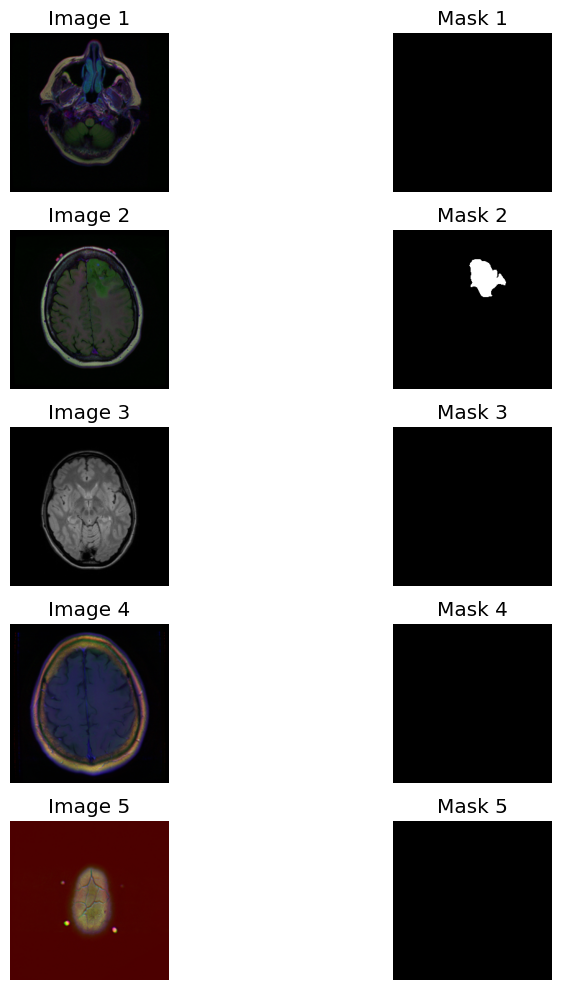

In [ ]:
import matplotlib.pyplot as plt
import cv2

num_images_to_show = 5  
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 10))

for i in range(num_images_to_show):
    image_path = train.iloc[i]['images'] 
    mask_path = train.iloc[i]['masks']   
    
    image = cv2.imread(image_path)  
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  

    image = cv2.resize(image, (256, 256))
    mask = cv2.resize(mask, (256, 256))

    # Convertir l'image pour l'affichage avec matplotlib (BGR -> RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(image_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i + 1}")
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Mask {i + 1}")

plt.tight_layout()
plt.show()


In [ ]:
val['images'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['images']), axis=1)
val['masks'] = val.apply(lambda row: os.path.join(DataPath, row['patient_id'], row['masks']), axis=1)

val_generator = data_generator(
    data_frame=val,  
    batch_size=8,       
    aug_dict={},         
    target_size=(256, 256)  
)


In [ ]:

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

def mlp(x, cf):
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x

def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

def deconv_block(x, num_filters):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)
    return x


def patch_embed_layer(x, patch_size, hidden_dim):
    patches = L.Reshape((cf["num_patches"], patch_size * patch_size * cf["num_channels"]))(x)
    patches = L.Dense(hidden_dim)(patches)
    return patches


def patch_embed_layer(x, patch_size, num_patches, hidden_dim):
    patches = L.Reshape((num_patches, patch_size * patch_size * 3))(x)  
    patches = L.Dense(hidden_dim)(patches)  
    return patches

def build_unetr_2d(cf):
    """ Inputs """
    input_shape = (cf["image_size"], cf["image_size"], cf["num_channels"])  
    inputs = L.Input(input_shape)  

    """ Patch Embedding """
    patch_size = cf["patch_size"]  
    num_patches = cf["num_patches"]  
    patches = patch_embed_layer(inputs, patch_size, num_patches, cf["hidden_dim"]) 

    # Position Embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = L.Embedding(input_dim=num_patches, output_dim=cf["hidden_dim"])(positions) 
    x = patches + pos_embed 

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"] + 1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)
    z3 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z3)
    z6 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z6)
    z9 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z9)
    z12 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z12)

    ## Decoder 1
    x = deconv_block(z12, 512)

    s = deconv_block(z9, 512)
    s = conv_block(s, 512)
    x = L.Concatenate()([x, s])

    x = conv_block(x, 512)
    x = conv_block(x, 512)

    ## Decoder 2
    x = deconv_block(x, 256)

    s = deconv_block(z6, 256)
    s = conv_block(s, 256)
    s = deconv_block(s, 256)
    s = conv_block(s, 256)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    ## Decoder 3
    x = deconv_block(x, 128)

    s = deconv_block(z3, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 4
    x = deconv_block(x, 64)

    s = conv_block(z0, 64)
    s = conv_block(s, 64)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    """ Output """
    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)

    return Model(inputs, outputs, name="UNETR_2D")



if __name__ == "__main__":
    config = {}
    config["image_size"] = 256
    config["num_layers"] = 12
    config["hidden_dim"] = 768
    config["mlp_dim"] = 3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 16
    config["num_channels"] = 3

    model = build_unetr_2d(config)
   

In [16]:
model.summary()

Model: "UNETR_2D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 256, 768)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256, 768)  │    590,592 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 768)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 768)  │      1,536 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 768)  │ 28,339,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 768)  │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 768)  │      1,536 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256, 3072) │  2,362,368 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 3072) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256, 768)  │  2,360,064 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256, 768)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 768)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 768)  │      1,536 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 768)  │ 28,339,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256, 768)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 768)  │      1,536 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256, 3072) │  2,362,368 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256, 3072) │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256, 768)  │  2,360,064 │ dropout_4[0][0] 

 Total params: 416,222,913 (1.55 GB)

 Trainable params: 416,216,001 (1.55 GB)

 Non-trainable params: 6,912 (27.00 KB)

In [ ]:
smooth = 1

def iou_score(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (union - intersection + smooth)
    return iou

def dice_coefficient(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    dice = (2 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    return dice

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduction = ReduceLROnPlateau(monitor='val_dice_coefficient', patience=8 , verbose=1, factor=0.4, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_dice_coefficient', min_delta=0.00001, patience=6, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('unet_model.keras', monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')


In [ ]:
from tensorflow.keras.metrics import Recall, Precision

learning_rate = 0.0001

model.compile(
    optimizer=Adam(learning_rate=learning_rate ), 
    loss=dice_coefficient_loss,
    metrics=[dice_coefficient, iou_score, Recall(), Precision()]
)
steps_per_epoch = int(len(train) / 8)
validation_steps = int(len(val) / 8)
print(steps_per_epoch)
print(validation_steps)
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[lr_reduction, model_checkpoint]
)



331
36
Found 2651 validated image filenames.
Found 2651 validated image filenames.
Epoch 1/100


I0000 00:00:1731857940.942614     127 service.cc:145] XLA service 0x785ba4001f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731857940.942670     127 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731858031.656989     127 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'copy_fusion_6', 56 bytes spill stores, 56 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_125', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_123', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_114', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - dice_coefficient: 0.0746 - iou_score: 0.0401 - loss: 0.9254 - precision: 0.0515 - recall: 0.8860Found 295 validated image filenames.
Found 295 validated image filenames.

Epoch 1: val_dice_coefficient improved from -inf to 0.05674, saving model to unet_model.keras
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - dice_coefficient: 0.1786 - iou_score: 0.1033 - loss: 0.8210 - precision: 0.2148 - recall: 0.6914
Epoch 2: val_dice_coefficient improved from 0.05674 to 0.24685, saving model to unet_model.keras
331/331 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - dice_coefficient: 0.1787 - iou_score: 0.1034 - loss: 0.8209 - precision: 0.2149 - recall: 0.6914 - val_dice_coefficient: 0.2468 - val_iou_score: 0.1471 - val_loss: 0.7524 - val_precision: 0.4101 - val_recall: 0.6045 - learning_rate: 1.0000e-04
Epoch 3/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - dice_coefficient: 0.2733 - iou_score: 0.1728 - loss: 0.7299 - precision: 0.3112 - recall: 0.6041
Epoch 3: 

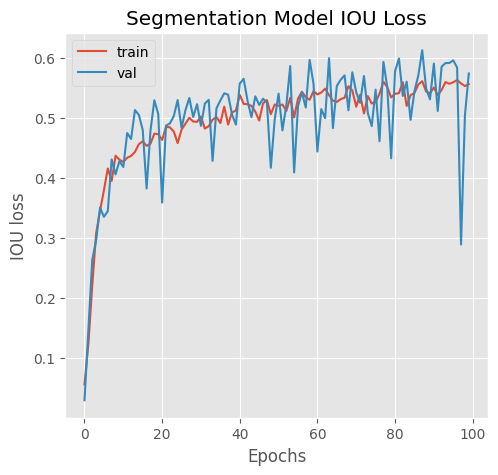

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['iou_score']);
plt.plot(history.history['val_iou_score']);
plt.title("Segmentation Model IOU Loss");
plt.ylabel("IOU loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

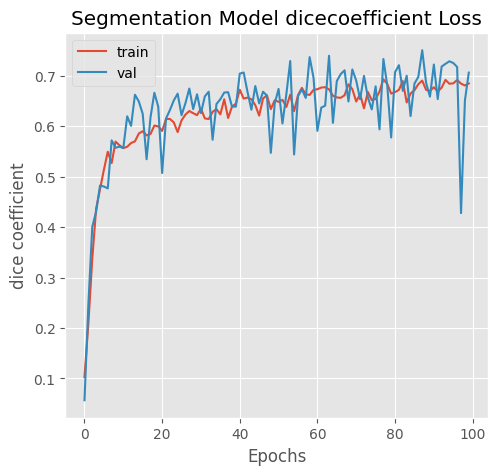

In [21]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['dice_coefficient']);
plt.plot(history.history['val_dice_coefficient']);
plt.title("Segmentation Model dicecoefficient Loss");
plt.ylabel("dice coefficient");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);


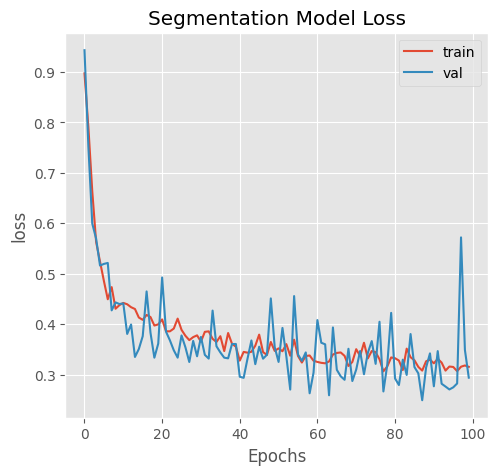

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Segmentation Model Loss");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
DataPath = "/kaggle/working/lgg_mri_segmentation/kaggle_3m/"

test['images'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['images'], axis=1)
test['masks'] = test.apply(lambda row: DataPath + row['patient_id'] + "/" + row['masks'], axis=1)

print(test.head())

                 patient_id  \
1006  TCGA_DU_7014_19860618   
1217  TCGA_DU_6404_19850629   
3267  TCGA_DU_6399_19830416   
2033  TCGA_DU_7300_19910814   
3419  TCGA_HT_A5RC_19990831   

                                                 images  \
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...   

                                                  masks  diagnosis  
1006  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
1217  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3267  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
2033  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          0  
3419  /kaggle/working/lgg_mri_segmentation/kaggle_3m...          1  


In [ ]:
def combined_generator(image_generator, mask_generator):
    while True:
        # Utilisation de zip pour combiner les deux générateurs
        image_batch, mask_batch = next(image_generator), next(mask_generator)
        yield image_batch, mask_batch

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = image_datagen.flow_from_dataframe(
    dataframe=test,  
    x_col="images",  
    class_mode=None, 
    color_mode="rgb", 
    target_size=(256, 256), 
    batch_size=32,
    seed=42,
    validate_filenames=False  

test_mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=test,  
    x_col="masks",  
    class_mode=None,  
    color_mode="grayscale",  
    target_size=(256, 256), 
    batch_size=32,
    seed=42,
    validate_filenames=False  
)

test_generator = combined_generator(test_image_generator, test_mask_generator)

steps_per_epoch_test = len(test) // 32 

test_loss, test_dice_coef, test_iou, test_recall, test_precision = model.evaluate(
    test_generator, steps=steps_per_epoch_test, verbose=1
)

print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {test_dice_coef}")
print(f"Test IoU: {test_iou}")
print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")

Found 983 non-validated image filenames.
Found 983 non-validated image filenames.
30/30 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - dice_coefficient: 0.7786 - iou_score: 0.6410 - loss: 0.2214 - precision: 0.8789 - recall: 0.6990
Test Loss: 0.23024533689022064
Test Dice Coefficient: 0.7697546482086182
Test IoU: 0.6298099756240845
Test Recall: 0.6931002140045166
Test Precision: 0.8793659806251526


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


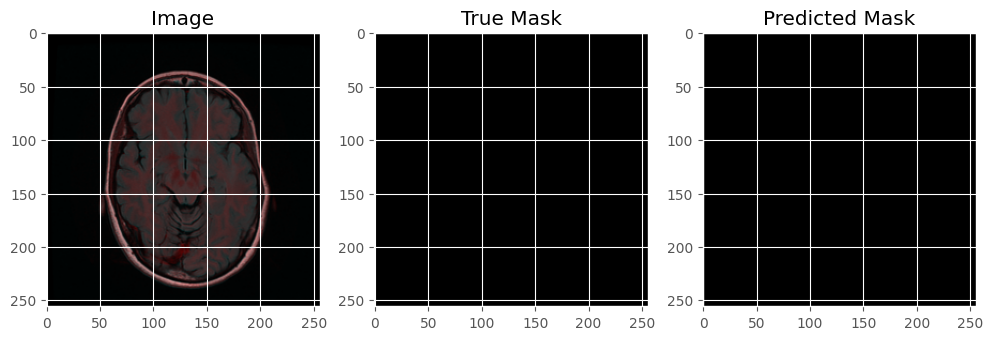

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


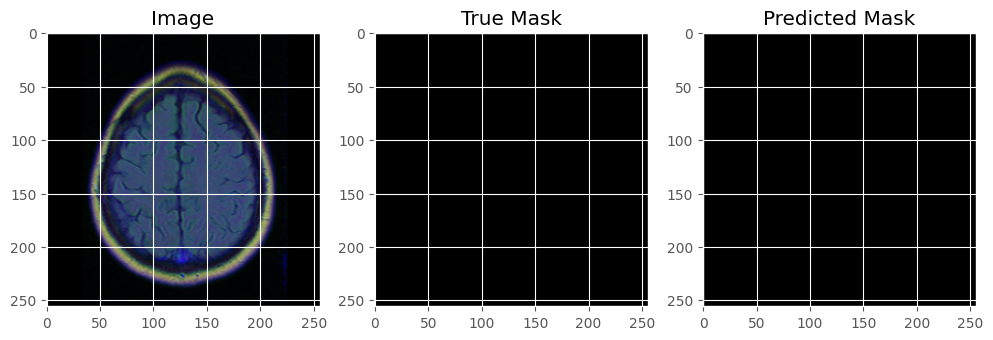

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


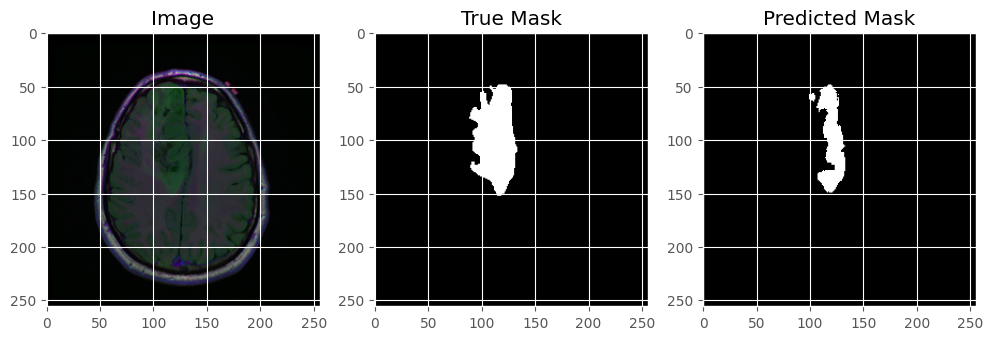

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


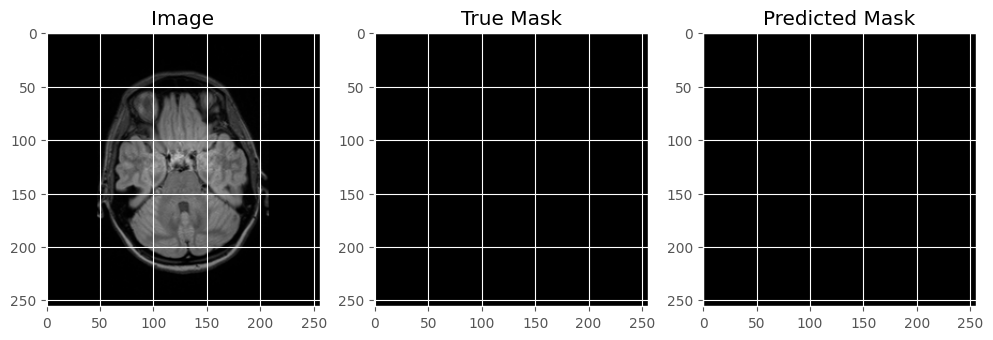

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


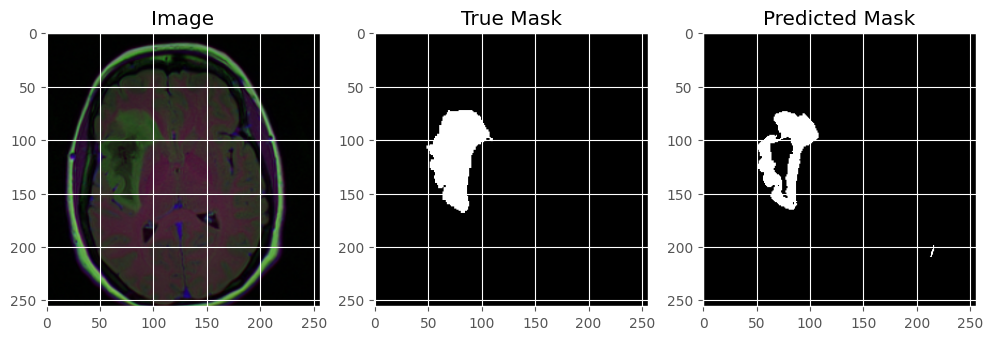

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


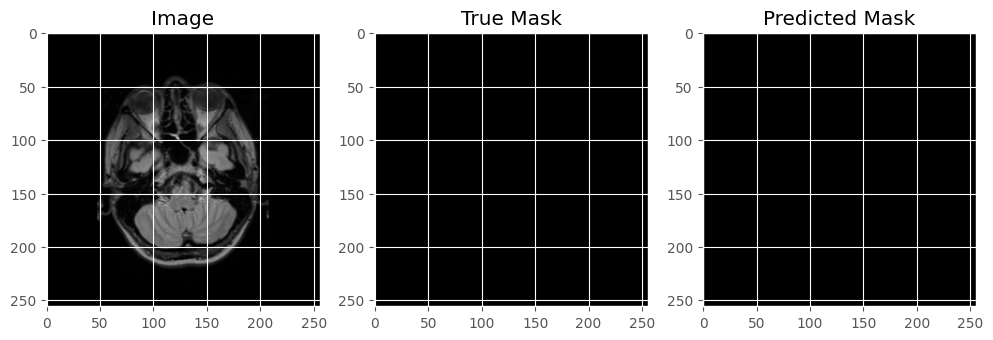

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(6):
    image, mask = next(test_generator)
    
    predicted_mask = model.predict(image)

    binary_predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image[0])

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask[0].squeeze(), cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(binary_predicted_mask[0].squeeze(), cmap="gray")

    plt.show()